We estimate the accuracy threshold of the toric code with measurement error.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag
from pymatching import Matching

In [2]:
def repetition_code(n):
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def x_stabilisers(L):
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

def x_logicals(L):
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    x_logicals = block_diag([kron(H1, H0), kron(H0, H1)])
    x_logicals.data = x_logicals.data % 2
    x_logicals.eliminate_zeros()
    return csc_matrix(x_logicals)

decoding_fail_noisy_measure_prob(H, logicals, p, q, num_shots, repetitions): 

Given: 

H: stabilizers

logicals: logical operators

p: probability of Z-error on each qubit

q: probability of measurement error

num_shots: number of simulations

repetitions: number of measurements

Returns:

the estimated probability that the minimum weight matching decoder fails to predict the true logical qubits correctly.

In [3]:
def decoding_fail_noisy_measure_prob(H, logicals, p, q, num_shots, repetitions):
    matching = Matching(H, weights=np.log((1-p)/p),
                repetitions=repetitions, timelike_weights=np.log((1-q)/q), faults_matrix=logicals)
    num_stabilisers, num_qubits = H.shape
    num_errors = 0
    for i in range(num_shots):
        noise_new = (np.random.rand(num_qubits, repetitions) < p).astype(np.uint8)
        noise_cumulative = (np.cumsum(noise_new, 1) % 2).astype(np.uint8)
        noise_total = noise_cumulative[:,-1]
        syndrome = H@noise_cumulative % 2
        syndrome_error = (np.random.rand(num_stabilisers, repetitions) < q).astype(np.uint8)
        syndrome_error[:,-1] = 0 # Perfect measurements in last round to ensure even parity
        noisy_syndrome = (syndrome + syndrome_error) % 2
        # Convert to difference syndrome
        noisy_syndrome[:,1:] = (noisy_syndrome[:,1:] - noisy_syndrome[:,0:-1]) % 2
        predicted_logicals_flipped = matching.decode(noisy_syndrome)
        actual_logicals_flipped = noise_total@logicals.T % 2
        if not np.array_equal(predicted_logicals_flipped, actual_logicals_flipped):
            num_errors += 1
    return num_errors / num_shots

In [9]:
%%time

num_shots = 3000
Ls = range(6,21,3)
ps = np.linspace(0.02, 0.04, 7)
log_errors_all_L = []
for L in Ls:
    Hx = x_stabilisers(L)
    logX = x_logicals(L)
    log_errors = []
    for p in ps:
        log_errors.append(decoding_fail_noisy_measure_prob(Hx, logX, p, p, num_shots, L))
    log_errors_all_L.append(np.array(log_errors))

CPU times: user 39.5 s, sys: 300 ms, total: 39.8 s
Wall time: 39.9 s


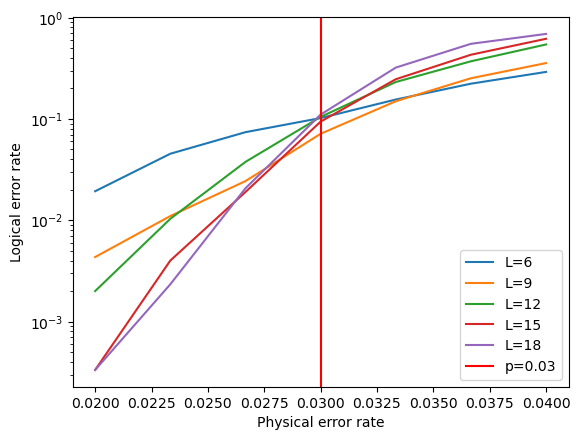

In [15]:
%matplotlib inline

plt.figure()
for L, logical_errors in zip(Ls, log_errors_all_L):
    plt.plot(ps, logical_errors, label="L={}".format(L))
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.axvline(x=0.03, c='red', label='p=0.03')
plt.legend()
plt.show()